In [39]:
from math import sqrt
import numpy as np
from pyscf import gto, scf, cc, fci, dft
import matplotlib.pyplot as plt
from nbed.driver import NbedDriver

In [7]:
def find_distance(r1, r2):
    return sqrt((r2[0]-r1[0])**2 + (r2[1]-r1[1])**2 + (r2[2]-r1[2])**2)

def find_point(r1, r2, d):
    R = find_distance(r1, r2)
    r2p = [r1[0] + (r2[0]-r1[0])*d/R, r1[1] + (r2[1]-r1[1])*d/R, r1[2] + (r2[2]-r1[2])*d/R]
    r2m = [r1[0] - (r2[0]-r1[0])*d/R, r1[1] - (r2[1]-r1[1])*d/R, r1[2] - (r2[2]-r1[2])*d/R]
    return r2p

def edit_xyz(filename, atom1_line_num, atom2_line_num, length, precision):
    with open(filename, 'r') as file:
        readlines = file.readlines()

    # ignoring white space so ['atom', 'x', 'y', 'z']
    atom1_line = readlines[atom1_line_num - 1].split()
    atom2_line = readlines[atom2_line_num - 1].split()

    print('fixed  atom: ', atom1_line)
    print('moving atom: ', atom2_line)

    # extracted xyz coordinates of atom 1 and 2:
    r1 = [float(atom1_line[1]), float(atom1_line[2]), float(atom1_line[3])]
    r2 = [float(atom2_line[1]), float(atom2_line[2]), float(atom2_line[3])]

    new_coords = find_point(r1, r2, length)
    new_line = atom2_line
    for i in range(3):
        new_line[i + 1] = str(round(new_coords[i], precision))

    new_line.append('\n')

    readlines[atom2_line_num - 1] = '    '.join(new_line)

    print('new coords : ', new_line)

    with open(filename, 'w') as file:
        file.writelines(readlines)

    with open(filename, 'r') as file:
        readlines = file.readlines()
    
    return readlines

In [88]:
filename = 'CH3F.xyz'
basis = 'sto-3g'
atom1_line_num = 4
atom2_line_num = 3
precision = 4
run_HF = True
run_CCSD = True
run_FCI = True

run_DFT = True

run_Nbed = True
active_atoms = 2

lengths = np.arange(0.85, 2.35, 0.10)
print(len(lengths), '\n')

hf_energies = np.zeros(len(lengths))
ccsd_energies = np.zeros(len(lengths))
fci_energies = np.zeros(len(lengths))
nbed_energies = np.zeros(len(lengths))
dft_energies = np.zeros(len(lengths))

nbed_config = {
    "geometry" : filename,
    "n_active_atoms" : active_atoms,
    "basis" : basis,
    "xc_functional" : "b3lyp",
    "projector" : "mu",
    "localization" : "spade",
    "convergence" : 1e-6,
    "run_virtual_localization" : True,
    "run_ccsd_emb" : True,
    "run_fci_emb" : False
}

for i in range(len(lengths)):
    print("%.2f" % lengths[i])
    data = edit_xyz(filename, atom1_line_num, atom2_line_num, length = lengths[i], precision = precision)
    print()

    mol = gto.M(atom = filename, basis = basis, spin = 0, charge = 0)

    #HF
    if run_HF:
        mf = scf.RHF(mol).run()
        hf_energies[i] = mf.e_tot

    #CCSD
    if run_CCSD:
        mf = scf.HF(mol).run()
        mycc = cc.CCSD(mf).run()
        ccsd_energies[i] = mycc.e_tot

    # FCI
    if run_FCI:
        myhf = mol.RHF().run()
        cisolver = fci.FCI(myhf)
        fci_energies[i] = cisolver.kernel()[0]

    # KSDFT
    if run_DFT:
        mf = dft.RKS(mol)
        mf.xc = 'lda,vwn'
        mf = mf.newton()
        dft_energies[i] = mf.kernel()

    # Nbed
    if run_Nbed:
        driver = NbedDriver(**nbed_config)
        driver._run_emb_CCSD(driver.embedded_scf)
        nbed_energies[i] = driver._mu["e_ccsd"]

    print()

# CH3F STO-3G run with FCI: 2m 44.4s

# CH3F 6-31G run without FCI: 10.6s
# CH3F cc-pvdz run without FCI: 34.0s


# mol1 sto-3g HF only: 11m 9.8s

15 

0.85
fixed  atom:  ['C', '-0.6783', '0.0000', '0.0000']
moving atom:  ['F', '1.5717', '0.0', '0.0']
new coords :  ['F', '0.1717', '0.0', '0.0', '\n']

converged SCF energy = -136.277247811962
converged SCF energy = -136.277247811962
E(CCSD) = -136.3556718324077  E_corr = -0.07842402044565092
converged SCF energy = -136.277247811962
converged SCF energy = -135.884739774734


Initialize <pyscf.gto.mole.Mole object at 0x7fb2f5ebb490> in <pyscf.dft.rks.RKS object at 0x7fb3091f7400>



0.95
fixed  atom:  ['C', '-0.6783', '0.0000', '0.0000']
moving atom:  ['F', '0.1717', '0.0', '0.0']
new coords :  ['F', '0.2717', '0.0', '0.0', '\n']

converged SCF energy = -136.708334372182
converged SCF energy = -136.708334372182
E(CCSD) = -136.7880959155483  E_corr = -0.07976154336598305
converged SCF energy = -136.708334372182
converged SCF energy = -136.306158128677


Initialize <pyscf.gto.mole.Mole object at 0x7fb307ef2b50> in <pyscf.dft.rks.RKS object at 0x7fb2f5ed5130>



1.05
fixed  atom:  ['C', '-0.6783', '0.0000', '0.0000']
moving atom:  ['F', '0.2717', '0.0', '0.0']
new coords :  ['F', '0.3717', '0.0', '0.0', '\n']

converged SCF energy = -136.948967464024
converged SCF energy = -136.948967464024
E(CCSD) = -137.0301853464023  E_corr = -0.08121788237833737
converged SCF energy = -136.948967464024
converged SCF energy = -136.538439584321


Initialize <pyscf.gto.mole.Mole object at 0x7fb2f5d9a370> in <pyscf.dft.rks.RKS object at 0x7fb2f5e708e0>



1.15
fixed  atom:  ['C', '-0.6783', '0.0000', '0.0000']
moving atom:  ['F', '0.3717', '0.0', '0.0']
new coords :  ['F', '0.4717', '0.0', '0.0', '\n']

converged SCF energy = -137.079045013883
converged SCF energy = -137.079045013883
E(CCSD) = -137.1624958009719  E_corr = -0.08345078708864387
converged SCF energy = -137.079045013883
converged SCF energy = -136.662281912952


Initialize <pyscf.gto.mole.Mole object at 0x7fb309214d00> in <pyscf.dft.rks.RKS object at 0x7fb30aef8430>



1.25
fixed  atom:  ['C', '-0.6783', '0.0000', '0.0000']
moving atom:  ['F', '0.4717', '0.0', '0.0']
new coords :  ['F', '0.5717', '0.0', '0.0', '\n']

converged SCF energy = -137.143031623064
converged SCF energy = -137.143031623064
E(CCSD) = -137.2299427362045  E_corr = -0.08691111314090927
converged SCF energy = -137.143031623064
converged SCF energy = -136.722965661476


Initialize <pyscf.gto.mole.Mole object at 0x7fb2f5d9adf0> in <pyscf.dft.rks.RKS object at 0x7fb2f5e70730>



1.35
fixed  atom:  ['C', '-0.6783', '0.0000', '0.0000']
moving atom:  ['F', '0.5717', '0.0', '0.0']
new coords :  ['F', '0.6717', '0.0', '0.0', '\n']

converged SCF energy = -137.166615297521
converged SCF energy = -137.166615297521
E(CCSD) = -137.2585607197277  E_corr = -0.09194542220705769
converged SCF energy = -137.166615297521
converged SCF energy = -136.746601479988


Initialize <pyscf.gto.mole.Mole object at 0x7fb2f5e708b0> in <pyscf.dft.rks.RKS object at 0x7fb2f5e9a130>



1.45
fixed  atom:  ['C', '-0.6783', '0.0000', '0.0000']
moving atom:  ['F', '0.6717', '0.0', '0.0']
new coords :  ['F', '0.7717', '0.0', '0.0', '\n']

converged SCF energy = -137.164884803585
converged SCF energy = -137.164884803585
E(CCSD) = -137.2637285313006  E_corr = -0.0988437277157825
converged SCF energy = -137.164884803585
converged SCF energy = -136.748209854876


Initialize <pyscf.gto.mole.Mole object at 0x7fb2f5eddc70> in <pyscf.dft.rks.RKS object at 0x7fb2f5e9a310>



1.55
fixed  atom:  ['C', '-0.6783', '0.0000', '0.0000']
moving atom:  ['F', '0.7717', '0.0', '0.0']
new coords :  ['F', '0.8717', '0.0', '0.0', '\n']

converged SCF energy = -137.147021284503
converged SCF energy = -137.147021284503
E(CCSD) = -137.2548613211835  E_corr = -0.1078400366804986
converged SCF energy = -137.147021284503
converged SCF energy = -136.736501012585


Initialize <pyscf.gto.mole.Mole object at 0x7fb308cf4ca0> in <pyscf.dft.rks.RKS object at 0x7fb2f5edd6a0>



1.65
fixed  atom:  ['C', '-0.6783', '0.0000', '0.0000']
moving atom:  ['F', '0.8717', '0.0', '0.0']
new coords :  ['F', '0.9717', '0.0', '0.0', '\n']

converged SCF energy = -137.119039209394
converged SCF energy = -137.119039209394
E(CCSD) = -137.2381428289742  E_corr = -0.1191036195797085
converged SCF energy = -137.119039209394
converged SCF energy = -136.716804073392


Initialize <pyscf.gto.mole.Mole object at 0x7fb2f4b639d0> in <pyscf.dft.rks.RKS object at 0x7fb2f5ecc910>



1.75
fixed  atom:  ['C', '-0.6783', '0.0000', '0.0000']
moving atom:  ['F', '0.9717', '0.0', '0.0']
new coords :  ['F', '1.0717', '0.0', '0.0', '\n']

converged SCF energy = -137.085211742463
converged SCF energy = -137.085211742463
E(CCSD) = -137.2179268829757  E_corr = -0.1327151405129889
converged SCF energy = -137.085211742463
converged SCF energy = -136.692674213065


Initialize <pyscf.gto.mole.Mole object at 0x7fb2f4b639d0> in <pyscf.dft.rks.RKS object at 0x7fb2f5ed53a0>



1.85
fixed  atom:  ['C', '-0.6783', '0.0000', '0.0000']
moving atom:  ['F', '1.0717', '0.0', '0.0']
new coords :  ['F', '1.1717', '0.0', '0.0', '\n']

converged SCF energy = -137.048691026361
converged SCF energy = -137.048691026361
E(CCSD) = -137.1973106130139  E_corr = -0.1486195866533271
converged SCF energy = -137.048691026361
converged SCF energy = -136.666627753239


Initialize <pyscf.gto.mole.Mole object at 0x7fb2f5e9a100> in <pyscf.dft.rks.RKS object at 0x7fb2f5ea1cd0>



1.95
fixed  atom:  ['C', '-0.6783', '0.0000', '0.0000']
moving atom:  ['F', '1.1717', '0.0', '0.0']
new coords :  ['F', '1.2717', '0.0', '0.0', '\n']

converged SCF energy = -137.011754477827
converged SCF energy = -137.011754477827
E(CCSD) = -137.1783328930856  E_corr = -0.1665784152587556
converged SCF energy = -137.011754477827
converged SCF energy = -136.640434765776


Initialize <pyscf.gto.mole.Mole object at 0x7fb2f4b639d0> in <pyscf.dft.rks.RKS object at 0x7fb2f5e8dbe0>



2.05
fixed  atom:  ['C', '-0.6783', '0.0000', '0.0000']
moving atom:  ['F', '1.2717', '0.0', '0.0']
new coords :  ['F', '1.3717', '0.0', '0.0', '\n']

converged SCF energy = -136.975948205464
converged SCF energy = -136.975948205464
E(CCSD) = -137.1621041908369  E_corr = -0.1861559853728301
converged SCF energy = -136.975948205464
converged SCF energy = -136.615264916151


Initialize <pyscf.gto.mole.Mole object at 0x7fb2f5815e80> in <pyscf.dft.rks.RKS object at 0x7fb2f5ecc6d0>



2.15
fixed  atom:  ['C', '-0.6783', '0.0000', '0.0000']
moving atom:  ['F', '1.3717', '0.0', '0.0']
new coords :  ['F', '1.4717', '0.0', '0.0', '\n']

converged SCF energy = -136.942234422072
converged SCF energy = -136.942234422072
E(CCSD) = -137.1489948256523  E_corr = -0.206760403580608
converged SCF energy = -136.942234422072
converged SCF energy = -136.591817414821


Initialize <pyscf.gto.mole.Mole object at 0x7fb309a7ddf0> in <pyscf.dft.rks.RKS object at 0x7fb2f5ec8580>



2.25
fixed  atom:  ['C', '-0.6783', '0.0000', '0.0000']
moving atom:  ['F', '1.4717', '0.0', '0.0']
new coords :  ['F', '1.5717', '0.0', '0.0', '\n']

converged SCF energy = -136.911148315002
converged SCF energy = -136.911148315002
E(CCSD) = -137.1388745622619  E_corr = -0.2277262472595059
converged SCF energy = -136.911148315002
converged SCF energy = -136.570455341967



Initialize <pyscf.gto.mole.Mole object at 0x7fb3091f7400> in <pyscf.dft.rks.RKS object at 0x7fb2f5e70670>


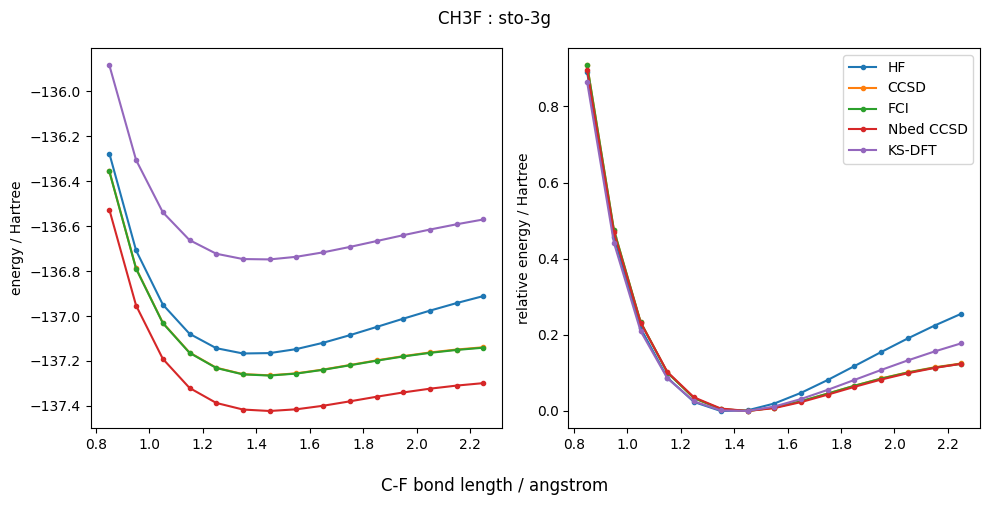

In [89]:
fig, (ax0, ax1) = plt.subplots(nrows = 1, ncols = 2, sharex = True, sharey = False, figsize = (10,5))

if run_HF:
    ax0.plot(lengths, hf_energies, label = 'HF', marker = '.')
    ax1.plot(lengths, hf_energies - np.min(hf_energies), label = 'HF', marker = '.')
if run_CCSD:
    ax0.plot(lengths, ccsd_energies, label = 'CCSD', marker = '.')
    ax1.plot(lengths, ccsd_energies - np.min(ccsd_energies), label = 'CCSD', marker = '.')
if run_FCI:
    ax0.plot(lengths, fci_energies, label = 'FCI', marker = '.')
    ax1.plot(lengths, fci_energies - np.min(fci_energies), label = 'FCI', marker = '.')
if run_Nbed:
    ax0.plot(lengths, nbed_energies, label = 'Nbed CCSD', marker = '.')
    ax1.plot(lengths, nbed_energies - np.min(nbed_energies), label = 'Nbed CCSD', marker = '.')
if run_DFT:
    ax0.plot(lengths, dft_energies, label = 'KS-DFT', marker = '.')
    ax1.plot(lengths, dft_energies - np.min(dft_energies), label = 'KS-DFT', marker = '.')
ax0.set_ylabel('energy / Hartree')
ax1.set_ylabel('relative energy / Hartree')
fig.suptitle(' '.join([filename[0:-4], ":", basis]))
fig.supxlabel('C-F bond length / angstrom')
plt.legend()
plt.tight_layout()
plt.show()

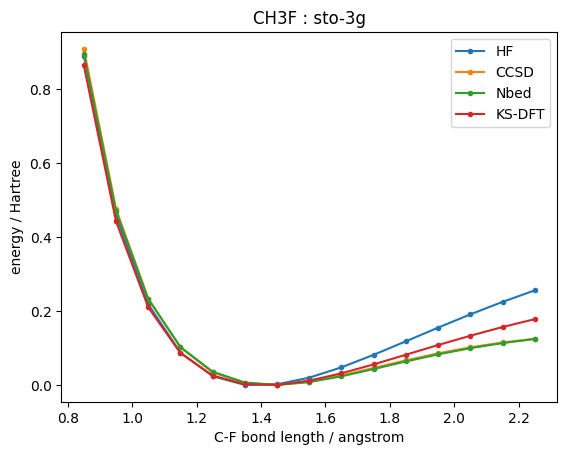

In [63]:
if run_HF:
    plt.plot(lengths, hf_energies - np.min(hf_energies), label = 'HF', marker = '.')
if run_CCSD:
    plt.plot(lengths, ccsd_energies - np.min(ccsd_energies), label = 'CCSD', marker = '.')
if run_FCI:
    plt.plot(lengths, fci_energies - np.min(fci_energies), label = 'FCI', marker = '.')
if run_Nbed:
    plt.plot(lengths, nbed_energies - np.min(nbed_energies), label = 'Nbed', marker = '.')
if run_DFT:
    plt.plot(lengths, dft_energies - np.min(dft_energies), label = 'KS-DFT', marker = '.')
plt.xlabel('C-F bond length / angstrom')
plt.ylabel('energy / Hartree')
plt.title(' '.join([filename[0:-4], ":", basis]))
plt.legend()
plt.show()